In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow.keras.utils import plot_model, pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam


from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import MinMaxScaler

from src.data import *
from src.plots import *
from src.models import *

2023-12-31 03:41:04.416440: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 03:41:04.450731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 03:41:04.450778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 03:41:04.451646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 03:41:04.456952: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 03:41:04.457786: I tensorflow/core/platform/cpu_feature_guard.cc:1

# The Task

 As a well-known data scientist, you were asked for help by a company producing candies. Some of their products are plagued with different types of defects. The whole manufacture is equipped with sensors so there are several time series describing the process of producing candies. They would like to achieve two goals:


1. Have a predictive model which will tell them if a given candy has a defect and which ones

2. Perform a root cause analysis - they would like to know what patterns in the data are related to defects



Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

# Data Creation

- For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 
- One candy can have zero, one or more defects at once.
- Patterns are of different length
- There is one defect related to a pattern occurring at two sensors simultaneously



In [2]:
np.random.seed(42)
SAMPLES = 50000
DEVICE = 'cpu'
DEVICES = tf.config.list_logical_devices(DEVICE)
STRATEGY = tf.distribute.MirroredStrategy(DEVICES)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


[False False False False False]


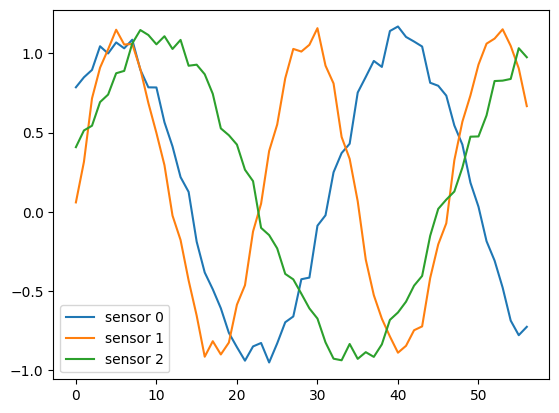

[False  True False False False]


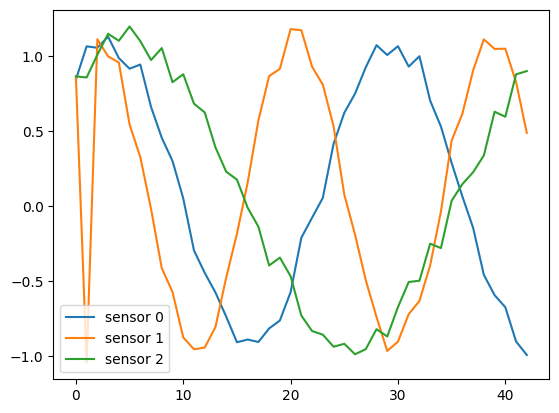

[ True False False False False]


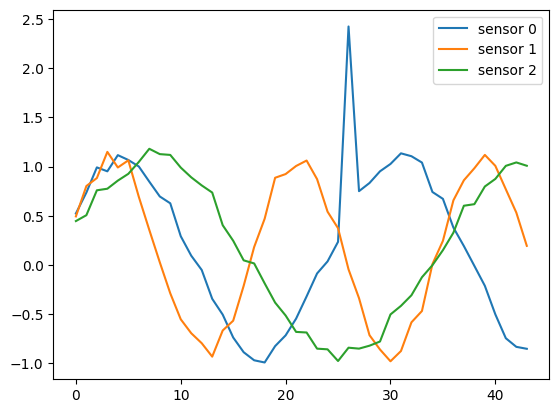

[False False False False False]


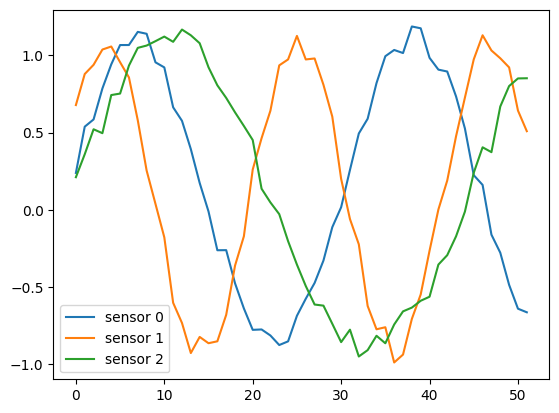

[False  True False False  True]


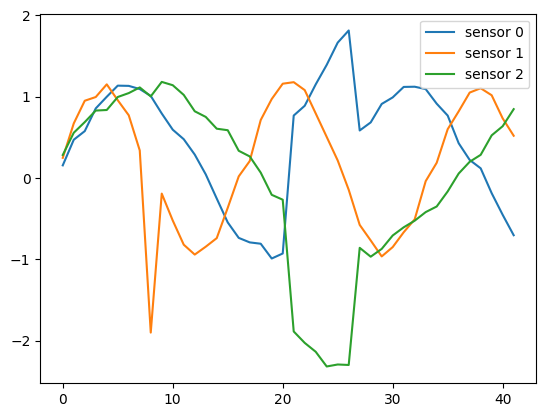

In [3]:
xl, yl = create_dataset(SAMPLES)
plot_sensors(xl,yl)

# Preprocess and split data

In [4]:
x_pad = pad_sequences(xl, dtype='float64', value=np.nan)
y = np.array(yl).astype(np.uint8)

In [5]:
samples, timesteps, features = x_pad.shape
x_pad.shape

(50000, 59, 3)

In [6]:
_, labels = y.shape
y.shape

(50000, 5)

In [7]:
scaler = MinMaxScaler()
x_pad = scaler.fit_transform(x_pad.reshape(-1, x_pad.shape[-1])).reshape(x_pad.shape)
X = np.nan_to_num(x_pad,nan=-2)

In [8]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

N = len(x_pad)
train_size,val_size,test_size = int(N*train_frac),int(N*val_frac),int(N*test_frac)
data_idx = list(range(N))
np.random.shuffle(data_idx)
train_idx,test_idx,val_idx = data_idx[:train_size],data_idx[-test_size:],data_idx[train_size+1:train_size+val_size]
X_train,y_train = X[train_idx],y[train_idx]
X_test,y_test = X[test_idx],y[test_idx]
X_val,y_val = X[val_idx],y[val_idx]

# The Model

In [9]:
with STRATEGY.scope():
	adam = Adam(learning_rate=0.001)
	model = create_encoder(timesteps, features, labels)
	model.build(input_shape=(None,features))
	model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 59, 3)             0         
                                                                 
 gru (GRU)                   (None, 59, 64)            13248     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                        

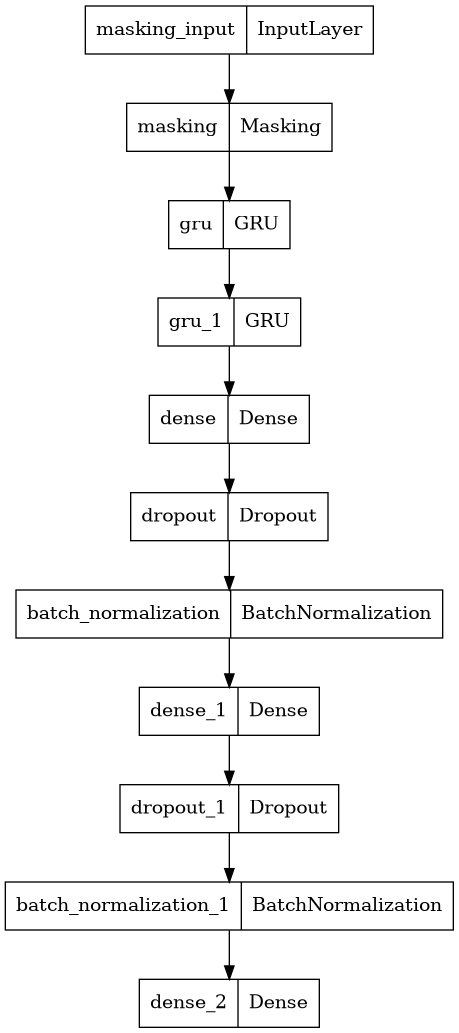

In [10]:
plot_model(model)

In [11]:
def learning_schedule(epoch,lr):
    return lr if epoch < 5 else lr * tf.math.exp(-0.1)

In [12]:
early = EarlyStopping(patience=3, restore_best_weights=True)
scheduler = LearningRateScheduler(learning_schedule)
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), batch_size=64, epochs=30, callbacks=[early,scheduler])

Epoch 1/30


2023-12-31 03:41:20.084817: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 25s 33ms/step - loss: 0.5581 - binary_accuracy: 0.7196 - val_loss: 0.3958 - val_binary_accuracy: 0.8288 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 0.4011 - binary_accuracy: 0.8225

2023-12-31 03:42:02.436820: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 18s 29ms/step - loss: 0.4011 - binary_accuracy: 0.8225 - val_loss: 0.3622 - val_binary_accuracy: 0.8453 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 18s 29ms/step - loss: 0.3370 - binary_accuracy: 0.8532 - val_loss: 0.3644 - val_binary_accuracy: 0.8081 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - ETA: 0s - loss: 0.2890 - binary_accuracy: 0.8778

2023-12-31 03:42:38.684196: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 18s 29ms/step - loss: 0.2890 - binary_accuracy: 0.8778 - val_loss: 0.4734 - val_binary_accuracy: 0.8112 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 19s 30ms/step - loss: 0.2601 - binary_accuracy: 0.8914 - val_loss: 0.3048 - val_binary_accuracy: 0.8541 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - ETA: 0s - loss: 0.2455 - binary_accuracy: 0.8972

2023-12-31 03:43:15.533662: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 18s 29ms/step - loss: 0.2455 - binary_accuracy: 0.8972 - val_loss: 0.2946 - val_binary_accuracy: 0.8889 - lr: 9.0484e-04
Epoch 7/30
625/625 [==============================] - 18s 29ms/step - loss: 0.2264 - binary_accuracy: 0.9055 - val_loss: 0.3008 - val_binary_accuracy: 0.8831 - lr: 8.1873e-04
Epoch 8/30
625/625 [==============================] - ETA: 0s - loss: 0.2083 - binary_accuracy: 0.9132

2023-12-31 03:43:52.212272: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 18s 29ms/step - loss: 0.2083 - binary_accuracy: 0.9132 - val_loss: 0.2116 - val_binary_accuracy: 0.9095 - lr: 7.4082e-04
Epoch 9/30
625/625 [==============================] - 18s 29ms/step - loss: 0.1936 - binary_accuracy: 0.9192 - val_loss: 0.1604 - val_binary_accuracy: 0.9331 - lr: 6.7032e-04
Epoch 10/30
625/625 [==============================] - ETA: 0s - loss: 0.1893 - binary_accuracy: 0.9206

2023-12-31 03:44:28.685581: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 18s 29ms/step - loss: 0.1893 - binary_accuracy: 0.9206 - val_loss: 0.2709 - val_binary_accuracy: 0.8999 - lr: 6.0653e-04
Epoch 11/30
625/625 [==============================] - 18s 29ms/step - loss: 0.1779 - binary_accuracy: 0.9254 - val_loss: 0.1966 - val_binary_accuracy: 0.9155 - lr: 5.4881e-04
Epoch 12/30
624/625 [============================>.] - ETA: 0s - loss: 0.1817 - binary_accuracy: 0.9246

2023-12-31 03:45:06.591817: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 20s 31ms/step - loss: 0.1817 - binary_accuracy: 0.9246 - val_loss: 0.1746 - val_binary_accuracy: 0.9301 - lr: 4.9659e-04


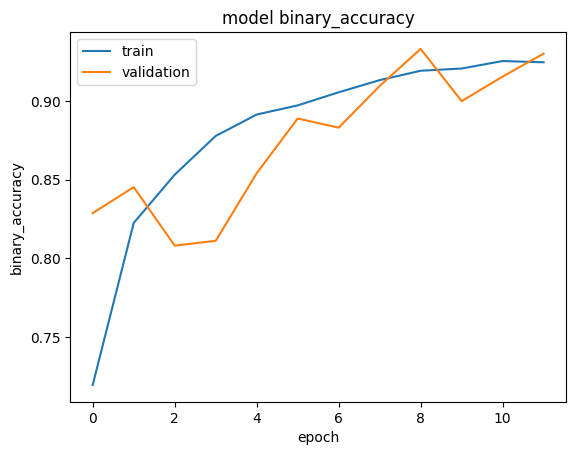

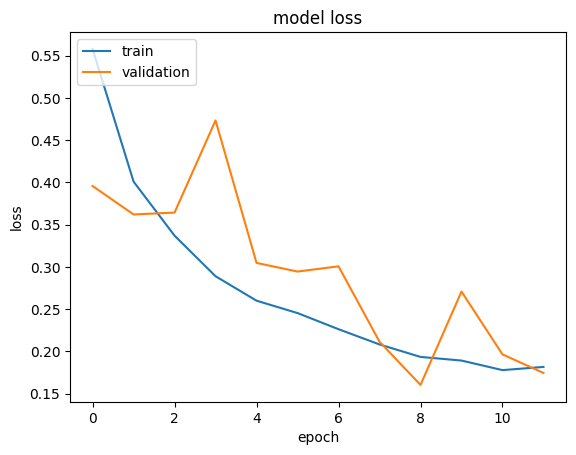

In [13]:
plot_history(history, metrics=['binary_accuracy'])

In [14]:
y_pred = model.predict(X_test)

2023-12-31 03:56:20.314493: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


157/157 [==============================] - 4s 11ms/step


In [15]:
model.evaluate(X_test,y_test)

157/157 [==============================] - 2s 11ms/step - loss: 0.1611 - binary_accuracy: 0.9320


[0.16109418869018555, 0.931999921798706]

In [16]:
y_pred

array([[1.4420225e-02, 9.9999994e-01, 2.4588047e-01, 1.3597485e-09,
        9.9999994e-01],
       [8.7851644e-05, 3.3828683e-02, 2.3718674e-01, 2.6164221e-04,
        1.5649161e-05],
       [2.7217546e-02, 4.3403637e-02, 2.4800734e-01, 1.2351336e-03,
        9.9999905e-01],
       ...,
       [2.7612215e-02, 9.9999976e-01, 2.6083991e-01, 6.7184076e-09,
        9.9999124e-01],
       [9.9370730e-01, 5.1782075e-02, 2.7571693e-01, 4.8460057e-03,
        4.3434845e-04],
       [5.0319696e-04, 1.3058369e-01, 2.5001124e-01, 9.9999774e-01,
        1.2994469e-04]], dtype=float32)

In [17]:
y_thresh = (y_pred > 0.5).astype(np.uint8)
y_thresh

array([[0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [18]:
y_test

array([[0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [19]:
[accuracy_score(y_test[:,j],y_thresh[:,j]) for j in range(labels)]

[0.9792, 0.9308, 0.75, 1.0, 1.0]

# Root Cause Analysis

In [20]:
with STRATEGY.scope():
	adam = Adam(learning_rate=0.001)
	autoencoder = create_autoencoder(timesteps, features, labels)
	autoencoder.build(input_shape=(None,features))
	autoencoder.compile(optimizer=adam, loss='mae', metrics=['mse'])

autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 59, 3)             0         
                                                                 
 gru_2 (GRU)                 (None, 59, 64)            13248     
                                                                 
 gru_3 (GRU)                 (None, 59, 32)            9408      
                                                                 
 bottleneck (Bottleneck)     (None, 59, 5)             585       
                                                                 
 gru_5 (GRU)                 (None, 59, 32)            3744      
                                                                 
 gru_6 (GRU)                 (None, 59, 64)            18816     
                                                                 
 time_distributed (TimeDist  (None, 59, 3)            

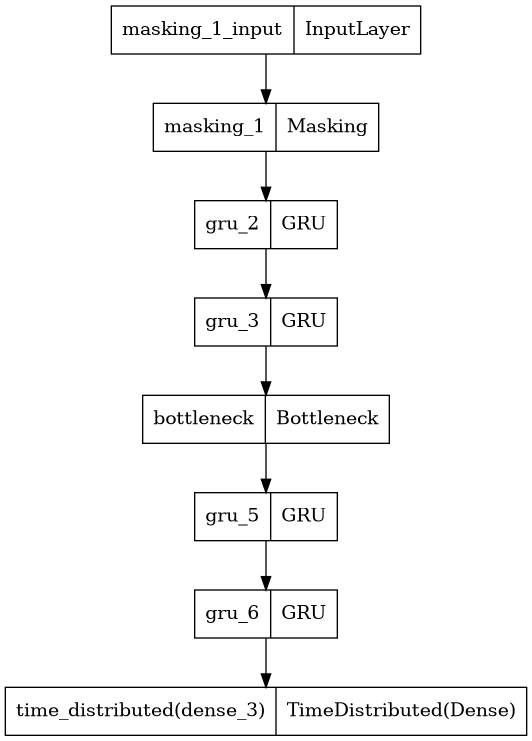

In [30]:
plot_model(autoencoder)

In [31]:
history = autoencoder.fit(X_train,X_train, validation_data=[X_val,X_val], batch_size=32, epochs=5, callbacks=[early, scheduler])

Epoch 1/5
1250/1250 [==============================] - ETA: 0s - loss: 0.0624 - mse: 0.0107

2023-12-31 02:22:30.005310: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 80s 58ms/step - loss: 0.0624 - mse: 0.0107 - val_loss: 0.0405 - val_mse: 0.0054 - lr: 0.0010
Epoch 2/5
1250/1250 [==============================] - ETA: 0s - loss: 0.0396 - mse: 0.0052

2023-12-31 02:23:42.433336: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 69s 55ms/step - loss: 0.0396 - mse: 0.0052 - val_loss: 0.0387 - val_mse: 0.0052 - lr: 0.0010
Epoch 3/5
1250/1250 [==============================] - ETA: 0s - loss: 0.0377 - mse: 0.0049

2023-12-31 02:24:51.729407: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 69s 55ms/step - loss: 0.0377 - mse: 0.0049 - val_loss: 0.0356 - val_mse: 0.0048 - lr: 0.0010
Epoch 4/5
1250/1250 [==============================] - ETA: 0s - loss: 0.0345 - mse: 0.0046

2023-12-31 02:26:01.070325: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 69s 55ms/step - loss: 0.0345 - mse: 0.0046 - val_loss: 0.0336 - val_mse: 0.0046 - lr: 0.0010
Epoch 5/5
1249/1250 [============================>.] - ETA: 0s - loss: 0.0328 - mse: 0.0045

2023-12-31 02:27:10.388112: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1250/1250 [==============================] - 69s 56ms/step - loss: 0.0328 - mse: 0.0045 - val_loss: 0.0318 - val_mse: 0.0045 - lr: 0.0010


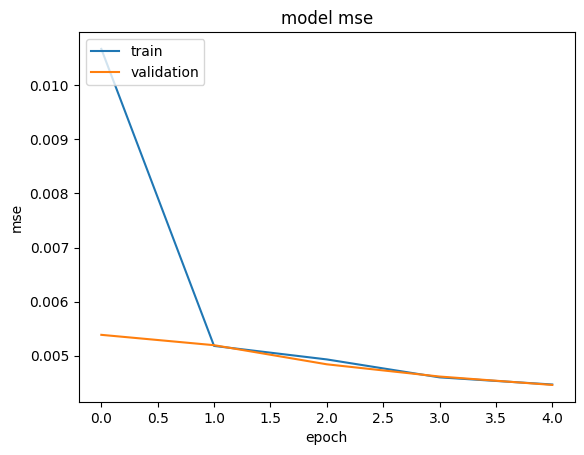

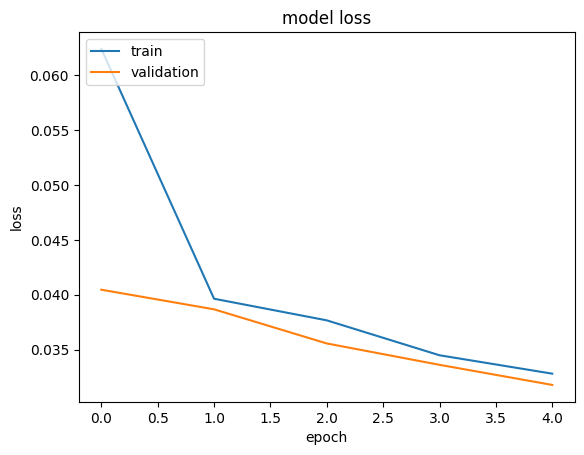

In [32]:
plot_history(history, metrics=['mse'])

In [33]:
X_pred = autoencoder.predict(X_test)

157/157 [==============================] - 7s 23ms/step


In [34]:
autoencoder.evaluate(X_test,X_test)

157/157 [==============================] - 4s 23ms/step - loss: 0.0317 - mse: 0.0045


[0.03169259801506996, 0.00445586908608675]

In [35]:
masking_layer = Masking(mask_value=-2)
masking_embedding = masking_layer(X_test)
mask = masking_embedding._keras_mask
X_pred[np.logical_not(mask)] = -2

In [36]:
mask

<tf.Tensor: shape=(5000, 59), dtype=bool, numpy=
array([[False, False, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])>

[False False False False  True]


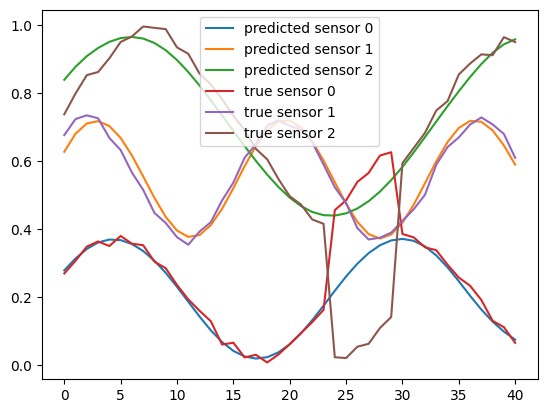

[False False  True False False]


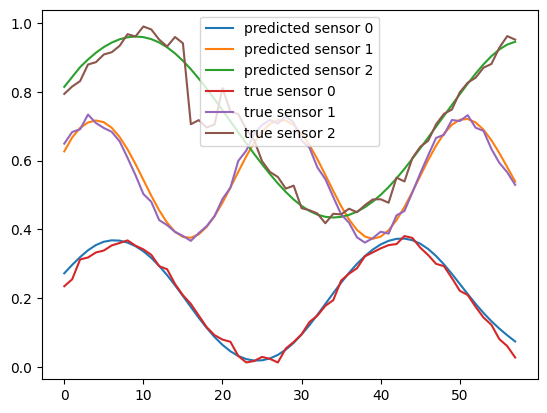

[ True False False False False]


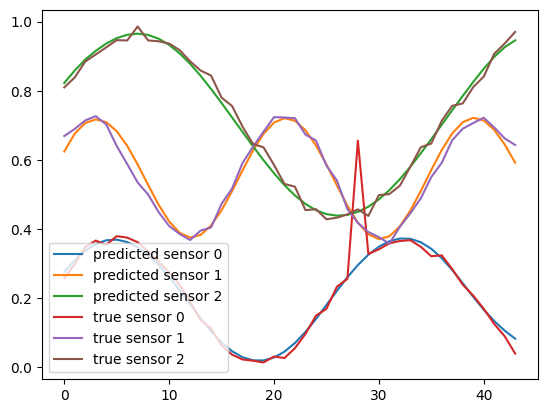

[False False False  True False]


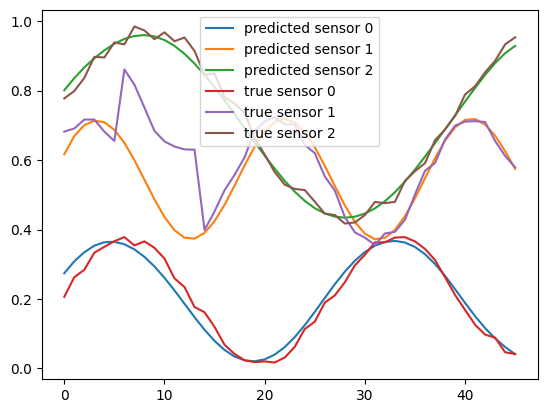

[False  True False False False]


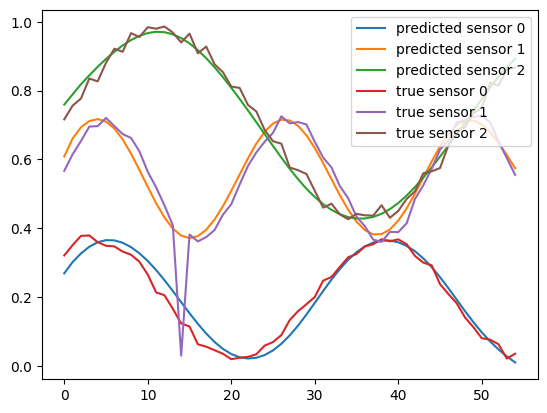

In [37]:
plot_sensor_comparison(X_pred,X_test,y_test,mask)

# TODO
root cause analysis using the autoencoder

In [38]:
train

NameError: name 'train' is not defined